## In this notebook, we will
1. Tune the learning rate for our NN model

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from decimal import Decimal

from tensorflow.keras.models import Sequential, model_from_json
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#Sklearn tools
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Keras specials
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.backend import clear_session

## Import training data and split into training+validation sets

In [4]:
features=pd.read_csv('../Data/features_train.csv',index_col=0)
target=pd.read_csv('../Data/target_train.csv',index_col=0)['ERed']

features_std = StandardScaler().fit_transform(features)

In [5]:
features_train,features_val,target_train,target_val=train_test_split(features_std,target,test_size=0.2,random_state=15)

In [7]:
features_train=tf.convert_to_tensor(features_train,dtype=tf.float64)
target_train=tf.convert_to_tensor(target_train,dtype=tf.float64)
features_val=tf.convert_to_tensor(features_val,dtype=tf.float64)
target_val=tf.convert_to_tensor(target_val,dtype=tf.float64)

## Define dictionary; which will store the NN performance metrics for varying learning rates

In [8]:
lr_grid={}

In [9]:
def nn_arch():
    
    num_dens_layers=4     
    n_nodes=[64, 32,16, 1]
    learning_rate=1e-3

    model = Sequential()
    model.add(Dense(n_nodes[0], kernel_initializer='normal',input_dim = features.shape[1], activation='relu')) # first hidden layer
    
    for i in range(1,num_dens_layers):
        model.add(Dense(n_nodes[i], kernel_initializer='normal',activation='relu'))    
    
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=lr), metrics=['mean_absolute_error'])
    
    return model

In [10]:
def lr_tuning(lr):

    model=nn_arch()
    
    history=model.fit(features_train, target_train, 
                      epochs=50, batch_size=32, 
                      validation_data = (features_val, target_val), verbose=0)
    
    training_loss=(history.history['mean_absolute_error'])
    validation_loss=(history.history['val_mean_absolute_error'])
    
    train_nn=model.predict(features_train)
    val_nn=model.predict(features_val)
    training_r2=r2_score(target_train,train_nn)
    validation_r2=r2_score(target_val,val_nn)
    
    temp={}
    temp['Training_loss']=training_loss
    temp['Validation_loss']=validation_loss
    temp['Training_r2']=training_r2
    temp['Validation_r2']=validation_r2
    
    lr_grid[str(lr)]=temp
    
    clear_session()

In [11]:
learning_rates=10**np.linspace(-4,0,5)
for lr in learning_rates:
    lr_tuning(lr)

28/28 [==============================] - 0s 3ms/step


## Plotting 'training loss vs epochs' for different learning rates

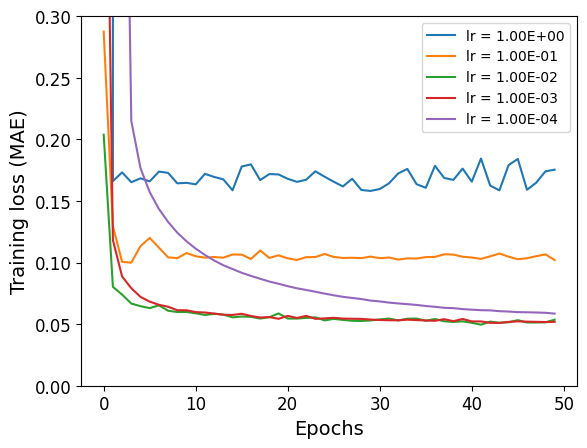

In [202]:
for k in list(lr_grid.keys())[::-1]:
    plt.plot(lr_grid[k]['Training_loss'],label='lr = '+'%.2E' % Decimal(k))
    plt.ylim([0,0.3])
plt.xlabel('Epochs',fontsize=14)    
plt.xticks(fontsize=12)
plt.ylabel('Training loss (MAE)',fontsize=14)    
plt.yticks(fontsize=12)
plt.legend()
plt.show()

## Comparing the training loss and validation loss for varying learning rates

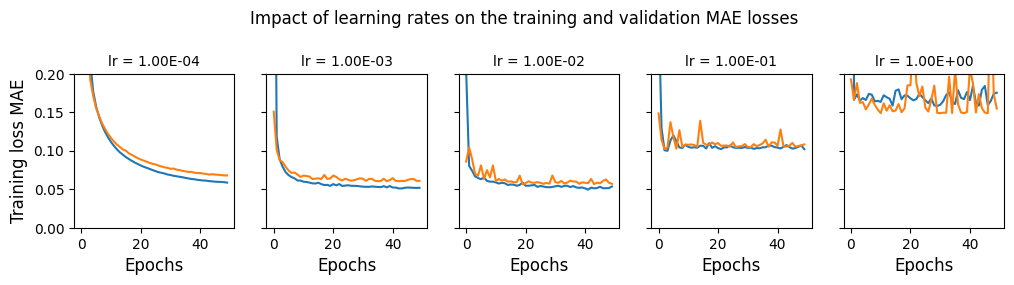

In [217]:
fig, ax = plt.subplots(1, len(learning_rates),figsize=(12,2),sharey=True)
rates=list(lr_grid.keys())
fig.suptitle('Impact of learning rates on the training and validation MAE losses',y=1.2)
for k in range(len(learning_rates)):
    ax[k].plot(lr_grid[rates[k]]['Training_loss'])
    ax[k].plot(lr_grid[rates[k]]['Validation_loss'])
    ax[k].set_ylim([0,0.2])
    ax[k].set_title('lr = '+'%.2E' % Decimal(learning_rates[k]),fontsize=10)
    ax[k].set_xlabel('Epochs',fontsize=12)
    ax[0].set_ylabel('Training loss MAE',fontsize=12)

## Comparing R2 values

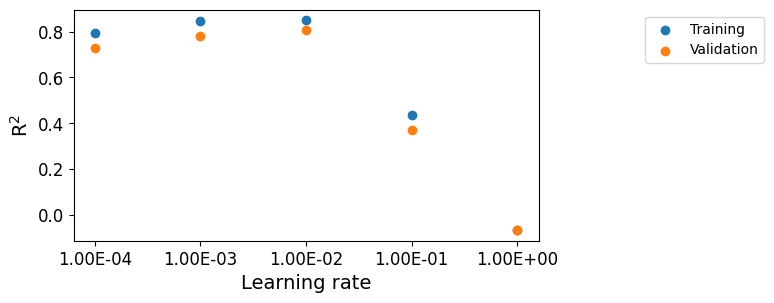

In [224]:
plt.figure(figsize=(6,3))
plt.scatter(range(len(learning_rates)),[lr_grid[k]['Training_r2'] for k in lr_grid.keys()],label='Training')
plt.scatter(range(len(learning_rates)),[lr_grid[k]['Validation_r2'] for k in lr_grid.keys()],label='Validation')
plt.xticks(range(len(learning_rates)),['%.2E' % Decimal(k) for k in learning_rates])
plt.legend(bbox_to_anchor=(1.5,1))
plt.xlabel('Learning rate',fontsize=14)    
plt.xticks(fontsize=12)
plt.ylabel('R$^2$',fontsize=14)    
plt.yticks(fontsize=12)
plt.show()

Very high learning rates (lr = 1e0) results in poor model performance, with training loss fluctuaing ~ 0.24

High learning rates (lr = 1e-1) results in poor model performance, with training loss fluctuaing ~ 0.15

Moderate learning rates (lr = le-3, 1e-4) result in rapid reduction of training loss. After 20 epochs, the loss fluctuates around 0.05.

Low learning rates (lr = 1e-5) leads to a slow decrement in the training loss with the number of epochs. As a result, the loss is ~ 0.6  even after training for 50 epochs.

## <font color='blue'>The tuned value of the learning rate is 1e-3</font>